### Neural Network Implementation

In [1]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TunedThresholdClassifierCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve,
    confusion_matrix, ConfusionMatrixDisplay
)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from sklearn.base import clone
from sklearn.metrics import balanced_accuracy_score
import numpy as np
import matplotlib.pyplot as plt

Downsampling code if needed later

In [2]:
"""
from sklearn.utils import resample

feature_df = scaled_df.copy()

df_majority = feature_df[feature_df["label"] == 1]
print("Majority shape is", df_majority.shape)
df_minority = feature_df[feature_df["label"] == 0]
print("Minority shape is", df_minority.shape)

df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority),
    random_state=561
)

balanced_df = pd.concat([df_majority_downsampled, df_minority], ignore_index=True)

# shuffle if you like
balanced_df = balanced_df.sample(frac=1, random_state=561).reset_index(drop=True)

# split features/labels again
y_balanced = balanced_df["label"]
X_balanced = balanced_df.drop(columns="label")
"""

'\nfrom sklearn.utils import resample\n\nfeature_df = scaled_df.copy()\n\ndf_majority = feature_df[feature_df["label"] == 1]\nprint("Majority shape is", df_majority.shape)\ndf_minority = feature_df[feature_df["label"] == 0]\nprint("Minority shape is", df_minority.shape)\n\ndf_majority_downsampled = resample(\n    df_majority,\n    replace=False,\n    n_samples=len(df_minority),\n    random_state=561\n)\n\nbalanced_df = pd.concat([df_majority_downsampled, df_minority], ignore_index=True)\n\n# shuffle if you like\nbalanced_df = balanced_df.sample(frac=1, random_state=561).reset_index(drop=True)\n\n# split features/labels again\ny_balanced = balanced_df["label"]\nX_balanced = balanced_df.drop(columns="label")\n'

### Load and Normalize Data

In [3]:
X = np.load("chr1/features/chr1_windows_X_unnorm.npy")
y = np.load("chr1/features/chr1_windows_y.npy")

print(X.shape, y.shape)
print("Successfully Loaded Data!")

(49869, 6) (49869,)
Successfully Loaded Data!


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y, shuffle=True)

mlp_pipe = Pipeline([("scaler", StandardScaler()), 
                      ("mlp", MLPClassifier(
                          hidden_layer_sizes = (64,64),
                          activation = 'relu',
                          solver = 'adam',
                          max_iter = 300, 
                          early_stopping = True,
                          n_iter_no_change = 10,
                          random_state = 561),
            
                      )])

### Model

In [5]:
param_grid = {"mlp__alpha": np.logspace(-4, 1, 6),
              "mlp__hidden_layer_sizes": [(64,), (64,), (64,64)]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=561)
sample_w = compute_sample_weight("balanced", y_train)
search = GridSearchCV(
    mlp_pipe,
    param_grid,
    cv=cv,
    scoring={
        "bal_acc": "balanced_accuracy",
        "roc_auc": "roc_auc",
        "ap": "average_precision",
    },
    refit="bal_acc",
    n_jobs=-1,
)
search.fit(X_train, y_train, mlp__sample_weight=sample_w)

print("Best params:", search.best_params_)
print("CV mean balanced accuracy:", search.cv_results_["mean_test_bal_acc"][search.best_index_])

best_mlp = search.best_estimator_
y_pred = best_mlp.predict(X_test)

Best params: {'mlp__alpha': np.float64(0.001), 'mlp__hidden_layer_sizes': (64, 64)}
CV mean balanced accuracy: 0.7528910563260788


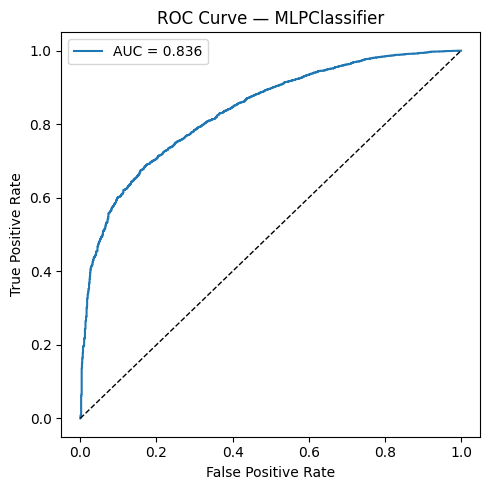

In [6]:
# Get predicted probability for the positive class
y_proba = best_mlp.predict_proba(X_test)[:, 1]

# Compute ROC points
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Compute AUC
auc = roc_auc_score(y_test, y_proba)

# Plot
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "k--", linewidth=1)  # random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — MLPClassifier")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
pos_acc = tp / (tp + fn)  # accuracy on positive windows
neg_acc = tn / (tn + fp)  # accuracy on negative windows
print(f"Positive accuracy: {pos_acc:.3f}")
print(f"Negative accuracy: {neg_acc:.3f}")

Positive accuracy: 0.723
Negative accuracy: 0.783


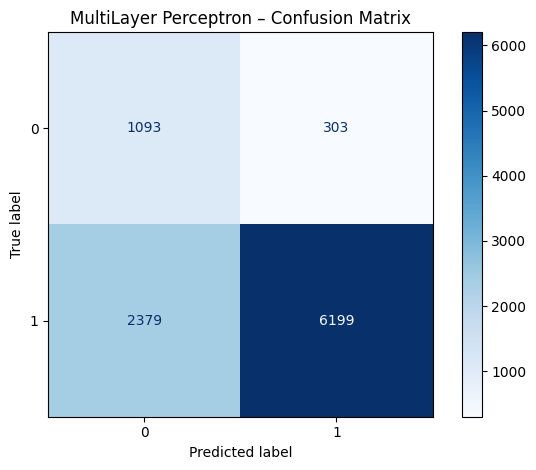

In [8]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("MultiLayer Perceptron – Confusion Matrix")
plt.tight_layout()
plt.show()

### Bootstrap

Balanced accuracy mean=0.595, std=0.016


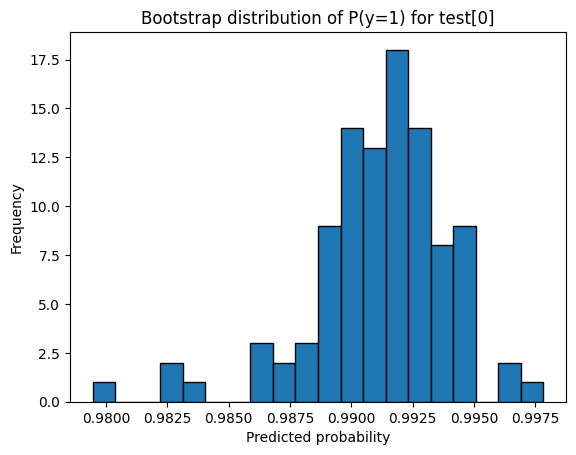

In [9]:
# after your GridSearchCV
best = search.best_estimator_          # full tuned pipeline
best_params = search.best_params_      # e.g., {'mlp__alpha': ...}

template = clone(best)  # preserves scaler + tuned MLP settings

bootstraps = 100
proba_matrix = np.zeros((bootstraps, len(y_test)))
bal_accs = []

for i in range(bootstraps):
    Xb, yb = resample(
        X_train, y_train,
        replace=True,
        n_samples=len(X_train),
        stratify=y_train,
        random_state=561 + i,
    )
    model = clone(template)
    model.fit(Xb, yb)
    proba = model.predict_proba(X_test)[:, 1]
    proba_matrix[i, :] = proba
    bal_accs.append(balanced_accuracy_score(y_test, (proba >= 0.5).astype(int)))

print(f"Balanced accuracy mean={np.mean(bal_accs):.3f}, std={np.std(bal_accs):.3f}")

# per-sample uncertainty on outputs
proba_mean = proba_matrix.mean(axis=0)
proba_std = proba_matrix.std(axis=0)
ci_low, ci_high = np.percentile(proba_matrix, [2.5, 97.5], axis=0)

# example: histogram of predicted probabilities for a single test point
plt.hist(proba_matrix[:, 0], bins=20, edgecolor="k")
plt.title("Bootstrap distribution of P(y=1) for test[0]")
plt.xlabel("Predicted probability")
plt.ylabel("Frequency")
plt.show()

Average uncertainty (std) across the test set: 0.0198


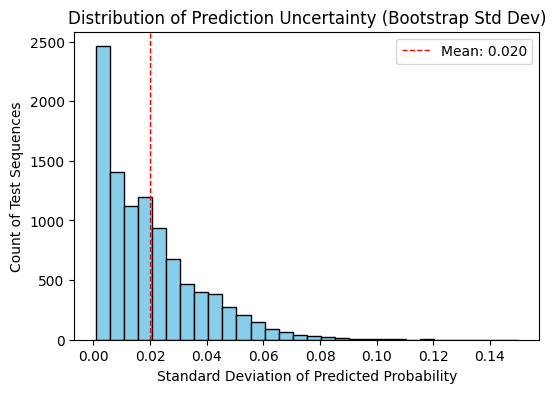


Most uncertain sequence indices: [4459 8035 5038 7678 4675]
Standard deviations for these: [0.11659989 0.1177918  0.11781565 0.12565916 0.1500239 ]


In [10]:
# 1. Calculate standard deviation for every single test point (axis=0 is across bootstraps)
all_stds = np.std(proba_matrix, axis=0)
mean_std = np.mean(all_stds)

print(f"Average uncertainty (std) across the test set: {mean_std:.4f}")

# 2. Plot the distribution of uncertainties
plt.figure(figsize=(6, 4))
plt.hist(all_stds, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Prediction Uncertainty (Bootstrap Std Dev)")
plt.xlabel("Standard Deviation of Predicted Probability")
plt.ylabel("Count of Test Sequences")
plt.axvline(mean_std, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_std:.3f}')
plt.legend()
plt.show()

# 3. Identify the most ambiguous sequences
# These are the sequences where the model changed its mind the most depending on the training set
most_uncertain_indices = np.argsort(all_stds)[-5:]  # Top 5 highest std
print("\nMost uncertain sequence indices:", most_uncertain_indices)
print("Standard deviations for these:", all_stds[most_uncertain_indices])